 # Homework #4
 
 By 👦Franklin Marsh👦
 
 MATH0154 Computational Statistics
 
 with Dr. 😂Gabe Chandler😂.

 # Problem 1

Consider drawing data from a mixture distribution of two normals, one with $\mu=7$ and one with $\mu=10$, both having $\sigma^2=.5$.  The observation is drawn from the first normal with probability $\delta$.  Thus, 
$$f(x)=\delta f(x|7, .5^2) + (1-\delta)f(x|10, .5^2)$$
where the RHS functions are normal pdfs. [5pt]

In [40]:
f <- function(x, delta = 0.7) {
    return(delta*dnorm(x,7,0.25) + (1 - delta)*dnorm(x,10,0.25))
}

Let's display a plot of the pdf:

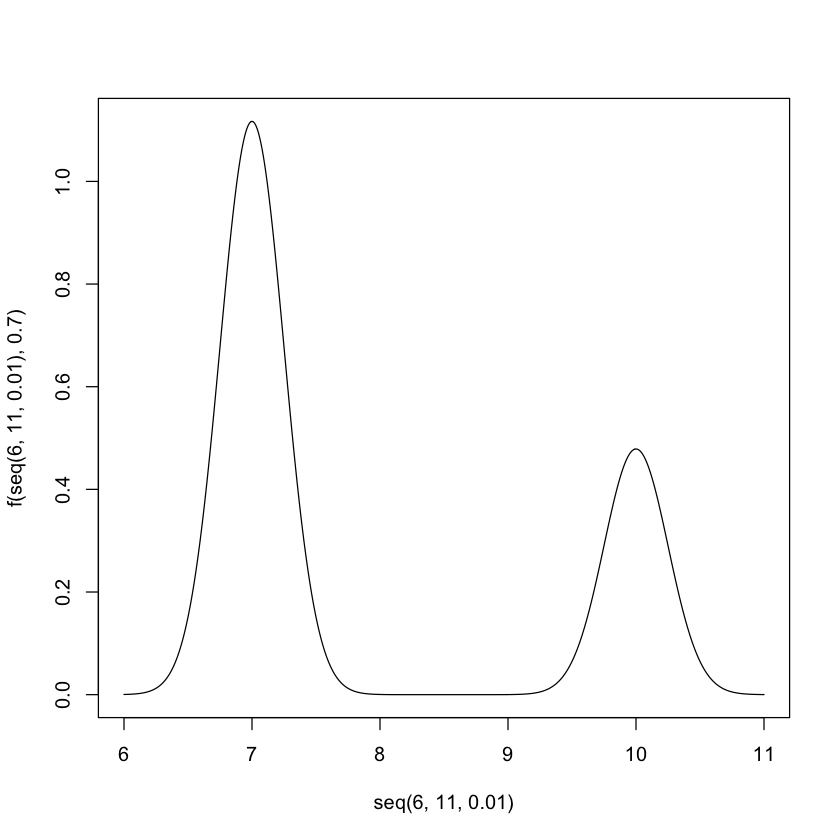

In [41]:
plot(seq(6,11,0.01),f(seq(6,11,0.01), 0.7), type= 'l')

 ## a)
a.  Write a function that samples from this distribution (so it will call $\delta$ as an argument).\\[5pt]


In [42]:
Draw <- function(n, delta) {
    #
    # Draws n random variates from the distribution f.
    #
    # Args:
    #    n: number of random variates to draw from the distribution.
    #    delta: delta parameter in distribution.
    # Returns:
    #    out: a list of n random variates drawn from f.
    
    out <- c()
    
    for (i in (1:n)) {
        
        if (runif(1) < delta) { #if a random uniform is less than delta
            out[i] <- rnorm(1,7,0.25) 
        }
    
        else {
            out[i] <- rnorm(1,10,0.25) 
        }
        }
    return(out)
}

 ## b)
b.  Let $\delta=.7$.  Sample $n=100$ observations from this distribution and present a histogram.\\[5pt]

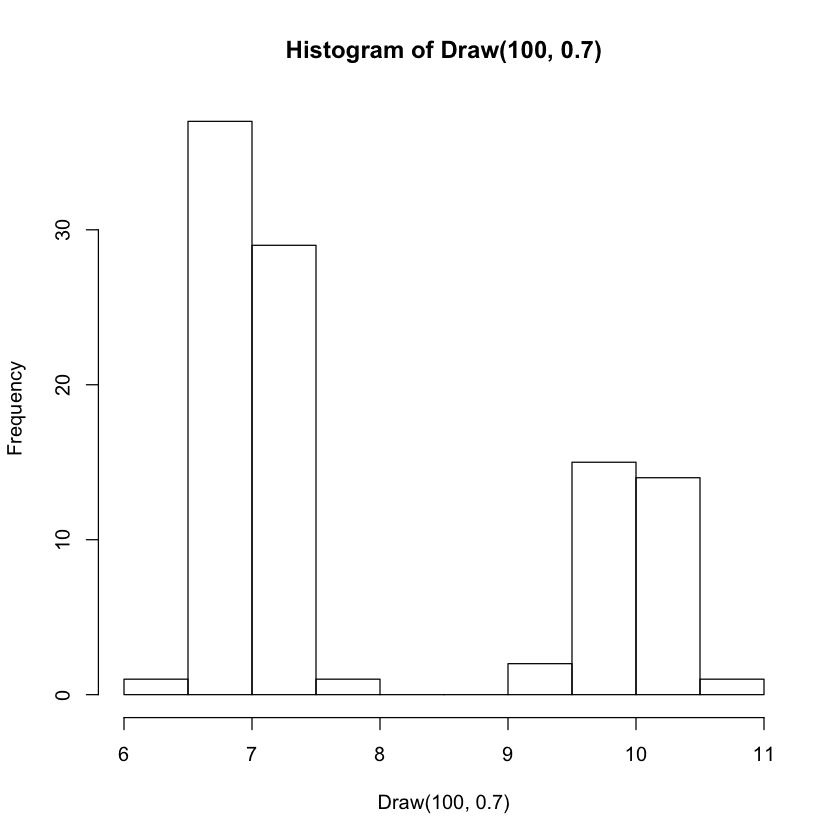

In [43]:
hist(Draw(100,0.7))

 ## c)

c. Consider a Bayesian analysis and find the posterior distribution of $\delta$ given that the prior distribution on $\delta$ is uniform (a so-called non-informative prior).  Plot a function that is proportional to the posterior distribution (the best you are going to be able to do)

Using Bayesian inference on this data set:

$f(\theta|x) \propto f(\theta) \Pi_{i=1}^{n} f(x_{i}|\theta)$

The prior is proportional to the uniform, so we can set $\theta = 1$ for the support.

In [56]:
Prior <- function(x) {
    #
    # 
    #
    # Args:
    #    
    #    
    # Returns:
    #    
    return(1.0)
}

BayesInf <- function(obs, f, prior, delta) {
    #
    # 
    #
    # Args:
    #    
    #    
    # Returns:
    #   
    
    terms <- c()
    
    i <- 0
    for (ob in obs) {
        i <- i + 1
        terms[i] <- f(ob, delta)
    }
    return(prior(delta)*prod(terms))
}

BayesGrid <- function(obs, f, prior, inputs) {
    #
    # 
    #
    # Args:
    #    
    #    
    # Returns:
    #   
    
    out <- c()
    i <- 0 
    
    for (p in inputs) {
        i <- i + 1
        out[i] <- BayesInf(obs, f, prior, p)
    }
    return(out)   
}

In [57]:
obs <- Draw(100,0.7)

We will now plot the posterior distribution of $\delta$. We can see that there is a peak around $\delta = 0.7$. This is the $\delta$ that we used to generate the distribution, so this is a good sign.

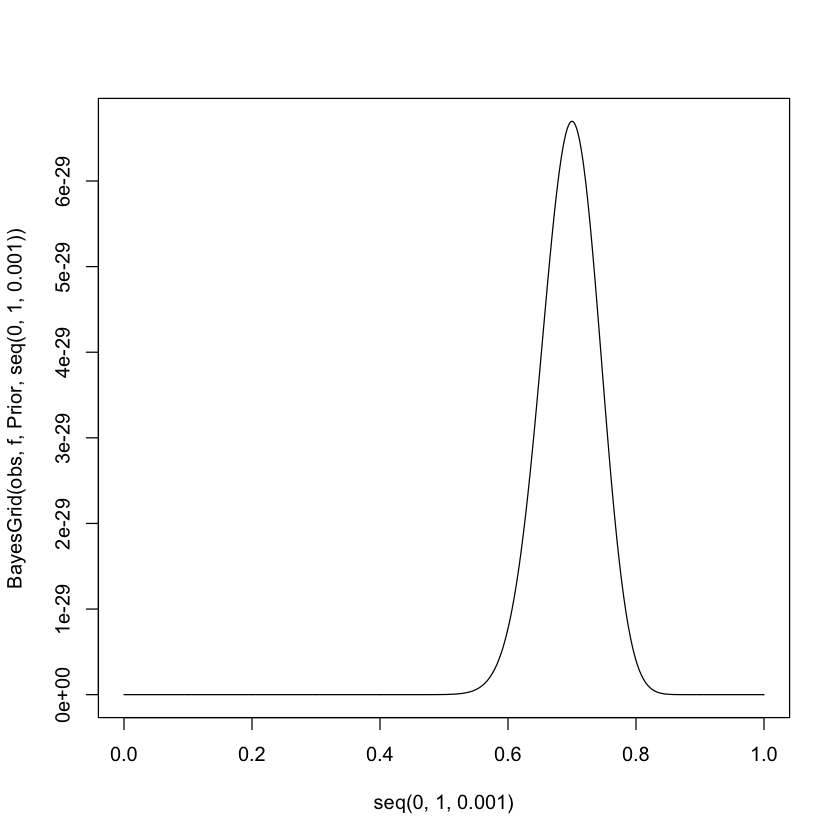

In [127]:
plot(seq(0,1,0.001), BayesGrid(obs, f, Prior, seq(0,1,0.001)), type = 'l')

 ## d)
 
d.  One estimate that is often used as a point estimate is the posterior mean.  Use an independence chain Metropolis Hastings algorithm to sample from the posterior and return an estimate using a candidate distribution that is uniform over the support (i.e. the candidate distribution is the same as the prior, which is often a good idea without other information).  Return the estimate of the posterior mean, and create plots that asses the 'mixing' of the chain (how quickly the chain explores the space). Use a starting value far from the true $\delta$, say $\delta_0=.1.$\\[5pt]

The Metropolis Hastings ratio (R) is:

$$R(u,v) = \frac{f(v)}{f(u)} \frac{g(u|v)}{g(v|u}) $$

with a uniform prior:

$$R(u,v) \Rightarrow \frac{g(u|v)}{g(v|u)} $$


In [153]:
MHStep <- function(x, eps, obs, f, prior) {
    
    y <- x + eps*runif(1,-1,1)
    
    met_ratio <- min(1,(BayesInf(obs,f,prior,y)/BayesInf(obs,f,prior,x)))
    
    if (runif(1) < met_ratio) {
        return(y)
        
    }
    
    else {
        return(x)  
    }
}

MH_alg <- function(x, eps, obs, f, prior, n_iters) {
    
    path <- c(x)
    
    for (i in (2:(n_iters + 1))) {
        path[i] <- MHStep(path[i-1], eps, obs, f, prior)
    }
    
    return(path)
}

IterMH_mean <- function(x, eps, obs, f, prior, iter_seq) {
    
    means <- c()
    
    for (i in (1:length(iter_seq))) {
        means[i] <- mean(MH_alg(x, eps, obs, f, prior, iter_seq[i]))
    }
    return(means)
}

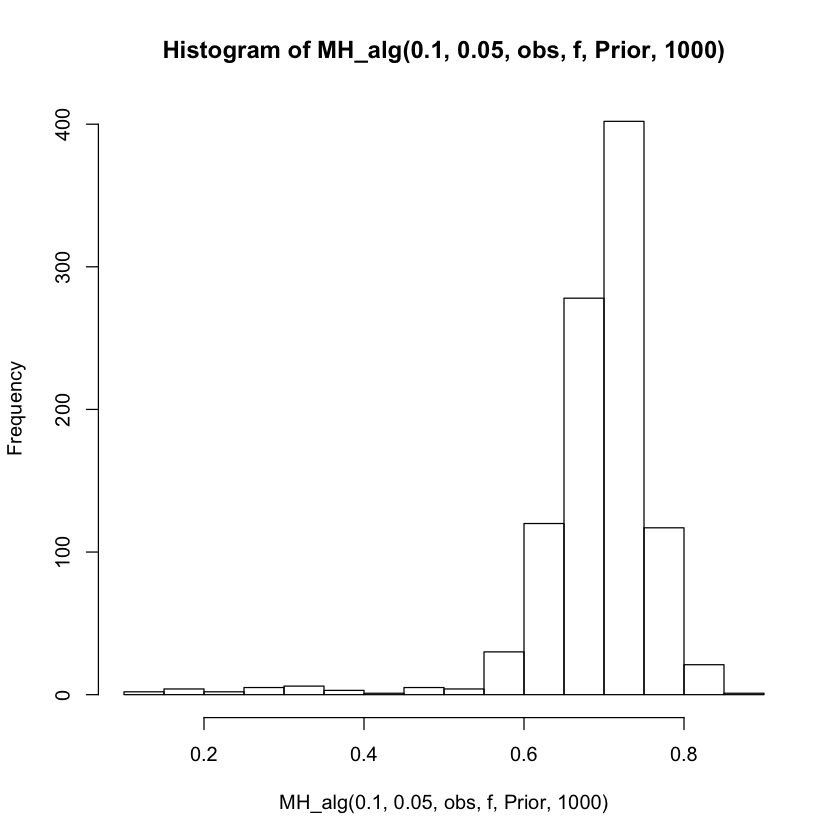

In [147]:
hist(MH_alg(0.1, 0.05, obs, f, Prior, 1000))

In [ ]:
iter_means <- IterMH_mean(0.1, 0.05,obs, f, Prior, seq(1,1000, by = 100))

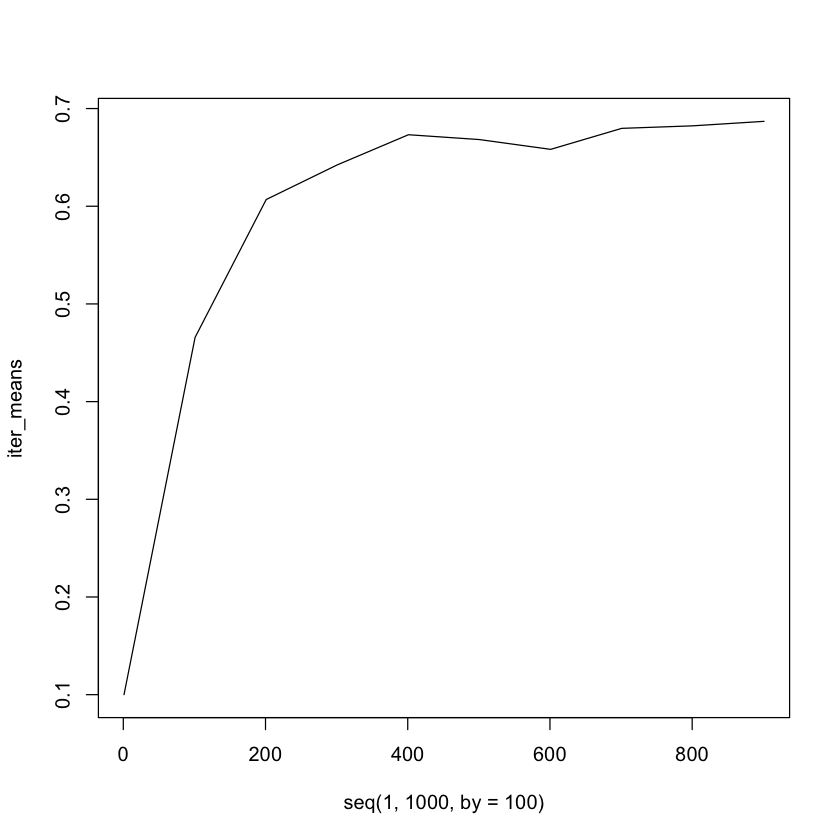

In [157]:
plot(seq(1,1000, by = 100),iter_means, type = 'l')

# Problem 2
 
Consider trying to estimate $\pi$ by performing a random walk inside the unit
square, where at each time point we select a point within a square centered at
your current location with side length $\epsilon$. We then look at the proportion of time
spent in the inscribed circle, which we suspect might approximate the area of
the circle, from which we can estimate the value of $\pi$. Consider two approaches:\\[5pt]

 ## a)
 
a. if you are offered to move outside the square, just ignore that value and do
it again until you are offered a `legal' point, but you move on each iteration.\\[5pt]

In [86]:
A_UnitWalk <- function(epsilon, n_iters, initial = c(0.0,0.0)) {
    
    x <- c(initial[1])
    y <- c(initial[2])
    dist <- c(sqrt(x^(2) + y^(2)))
        
    for (i in (2:(n_iters + 1))) {
        
        newx <- (x[i-1] + runif(1,-epsilon,epsilon)[1]) 
        newy <- (y[i-1] + runif(1,-epsilon,epsilon)[1]) 
        
        while (abs(newx) > 0.5 | abs(newy) > 0.5) {
            newx <- (x[i-1] + runif(1,-epsilon,epsilon)[1]) 
            newy <- (y[i-1] + runif(1,-epsilon,epsilon)[1]) 
            
            }

        x[i] <- newx
        y[i] <- newy
        dist[i] <- sqrt(newx^(2) + newy^(2))
           
        }   
     
    return(data.frame(x,y,dist))
}

In [171]:
A_walk <- A_UnitWalk(0.1, 10000)

In [131]:
head(A_walk)

,x,y,dist
1,0,0,0
2,-0.02437151,0.01841545,0.03054667
3,-0.05430019,-0.06773976,0.08681697
4,-0.06260117,-0.03003455,0.06943328
5,-0.152463879,0.008530315,0.152702327
6,-0.12891288,-0.03574339,0.13377638


We will now write a function to calculate Pi, given a dataframe like the dataframe above.

In [129]:
CalcPi <- function(square) {
    #
    # A function to calculate pi, given a dataframe of x, y coordinates and distances from the center for randomly drawn
    # points in 2D.
    #
    # Args:
    #    square:
    # Returns:
    #    pi_estimate
    #


    #subset the dataframe
    in_circle <- subset(square, subset = (dist < 0.5)) #find the points in the circle
    out_circle <- subset(square, subset = (dist >= 0.5)) #find the points out of the circle

    #plot the points 
    plot(out_circle$x,out_circle$y, pch = '.',
        xlim = c(-0.5,0.5), ylim = c(-0.5,0.5))
    points(in_circle$x,in_circle$y, 
        xlim = c(-0.5,0.5), ylim = c(-0.5,0.5),pch = '.', col = 'blue')

    #estimate pi
    pi_estimate <- (length(in_circle$x)/(length(out_circle$x) + length(in_circle$x)))*4.0
    print(pi_estimate)
    
    return(pi_estimate)
    }

[1] 3.318868


[1] 3.318868

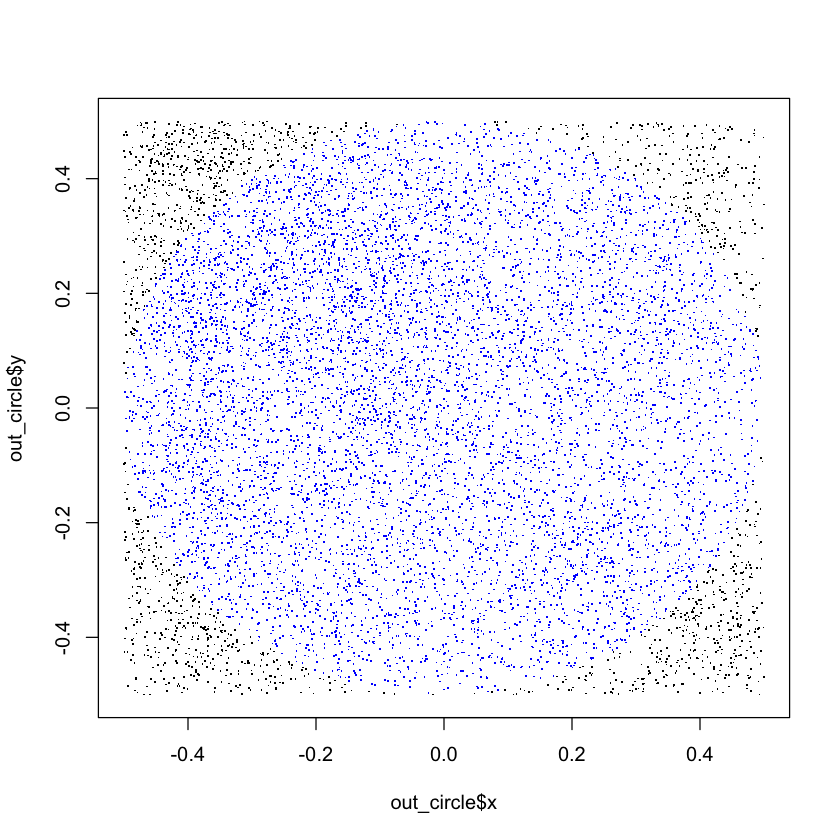

In [172]:
CalcPi(A_walk)

In [94]:
UnitSquare <- function(n_iters) {
    
    x <- c()
    y <- c()
    dist <- c()
        
    for (i in (1:(n_iters))) {
        x[i] <- runif(1,-0.5,0.5)
        y[i] <- runif(1,-0.5,0.5)
        dist[i] <- sqrt(x[i]^(2) + y[i]^(2))
    }
    
    return(data.frame(x,y,dist))

}

In [95]:
square <- UnitSquare(10000) #run the simulation

 ## b)
 
b. do the same as in (a), except once you are offered a legal point, only move to
that point with a probability given by the Metropolis ratio.\\[5pt]

In [205]:
B_UnitWalk <- function(epsilon, n_iters, initial = c(0.0,0.0)) {
    #
    # 
    #
    # Args:
    #    
    #    
    # Returns:
    #   
    
    
    x <- c(initial[1])
    y <- c(initial[2])
    dist <- c(sqrt(x^(2) + y^(2)))
        
    for (i in (2:(n_iters + 1))) {
        
        newx <- (x[i-1] + runif(1,-epsilon,epsilon)[1]) 
        newy <- (y[i-1] + runif(1,-epsilon,epsilon)[1]) 
             
        met_ratio <- min(1, (((epsilon - abs(newx) + 0.5)*(epsilon - abs(newy) + 0.5))/(4*epsilon^(2.0))))
        #met_ratio <- min(1, ((4*epsilon^(2.0))/((epsilon - abs(newx) + 0.5)*(epsilon - abs(newy) + 0.5))))
        
        if (runif(1) < met_ratio) { #update according to the probability
            
            x[i] <- newx
            y[i] <- newy
            dist[i] <- sqrt(newx^(2) + newy^(2))
            
        }
        
        else {
            x[i] <- x[i-1]
            y[i] <- y[i-1]
            dist[i] <- sqrt(x[i-1]^(2) + y[i-1]^(2))
        }
    }    
    return(data.frame(x,y,dist))
}

[1] 26.88696
[1] 27.62629
[1] 25.14906
[1] 27.15655
[1] 28.50049
[1] 28.64514
[1] 26.65393
[1] 27.43934
[1] 25.63085
[1] 27.92986
[1] 26.45464
[1] 24.72019
[1] 24.89897
[1] 22.33409
[1] 20.07992
[1] 21.29978
[1] 19.68699
[1] 19.24045
[1] 20.91919
[1] 22.74762
[1] 23.6254
[1] 24.64395
[1] 23.0997
[1] 22.76828
[1] 23.21181
[1] 22.72914
[1] 22.75232
[1] 21.05015
[1] 21.05687
[1] 20.48687
[1] 17.62552
[1] 20.65471
[1] 19.82191
[1] 19.15717
[1] 18.70469
[1] 17.2381
[1] 18.77565
[1] 20.36482
[1] 20.93712
[1] 21.01332
[1] 17.20798
[1] 16.2468
[1] 15.94891
[1] 15.31046
[1] 14.99333
[1] 15.90845
[1] 16.85549
[1] 16.35037
[1] 14.57574
[1] 14.81532
[1] 14.53108
[1] 11.61034
[1] 14.45901
[1] 15.47419
[1] 15.05103
[1] 15.21052
[1] 17.2161
[1] 16.70176
[1] 19.94544
[1] 19.78436
[1] 18.90994
[1] 18.02174
[1] 16.26853
[1] 15.84027
[1] 15.32992
[1] 16.40221
[1] 15.29631
[1] 15.29016
[1] 15.40817
[1] 14.57292
[1] 13.02337
[1] 12.63968
[1] 14.64759
[1] 13.13116
[1] 15.97161
[1] 16.69078
[1] 14.62292
[1] 

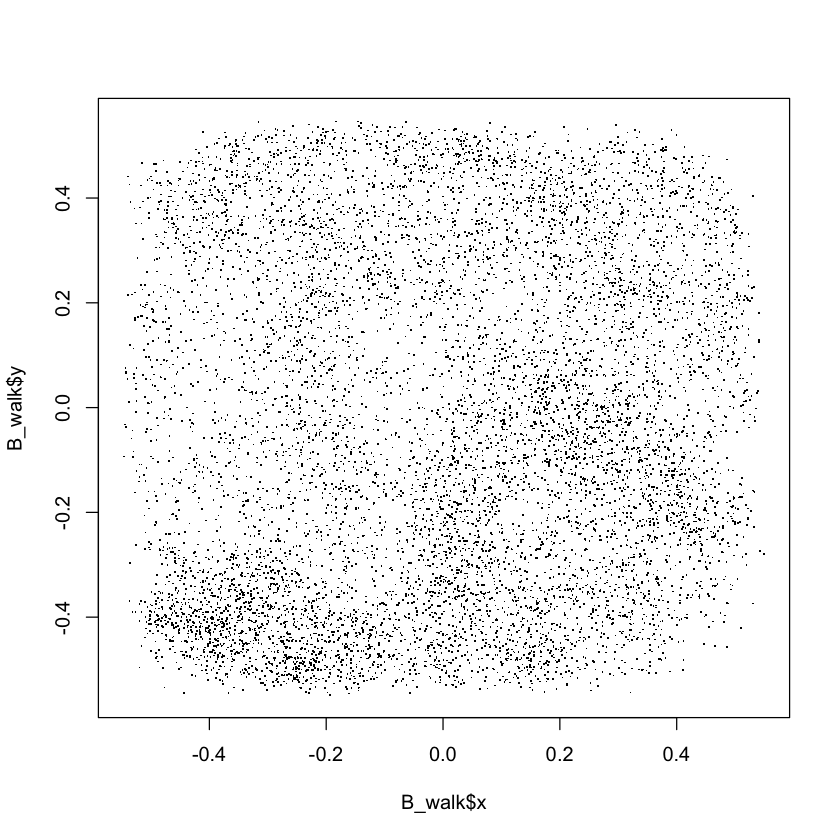

In [207]:
B_walk <- B_UnitWalk(0.05,10000)
plot(B_walk$x, B_walk$y, pch = '.')

[1] 2.70293


[1] 2.70293

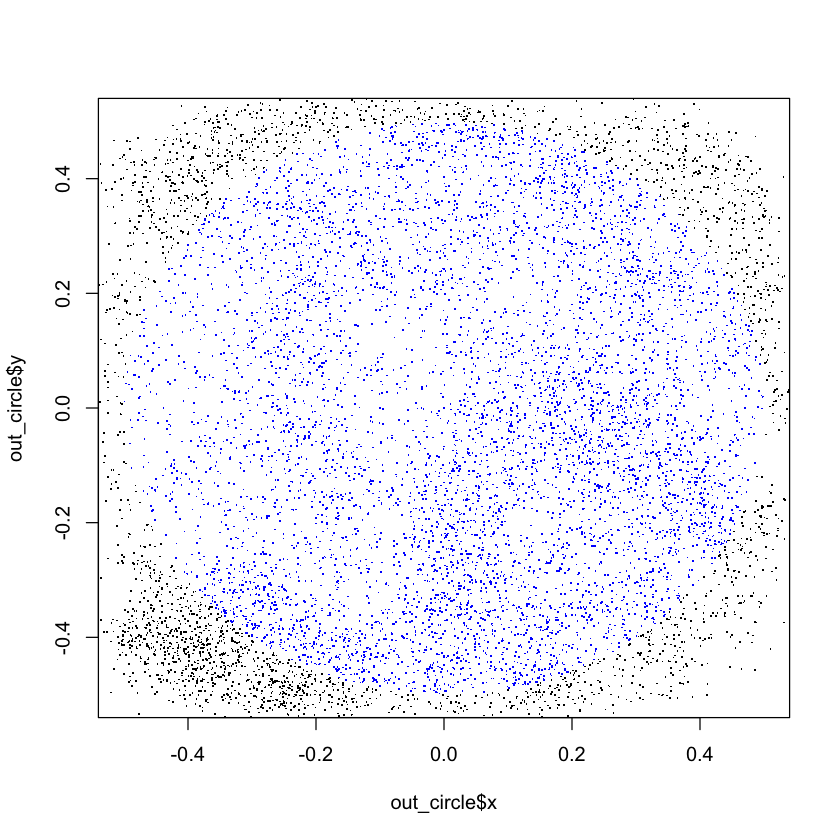

In [208]:
CalcPi(B_walk)

## c)

c. How does the value of $\epsilon$ affect the estimate of $\pi$ in (a)? Give a brief explanation
of why (b) works but (a) does not.

Algorithm (a) tends to overestimate Pi because the points are drawn from the center of the circle too frequently. If a point is drawn within $\epsilon$ from the edge of the unit square, there is a chance that the choice will be rejected and that the point will have to be redrawn.  

Algorithm (b) works correctly because